# Selecting good features: univariate selection
<p> There are in general two reasons why feature selection is used: </p>
<li> a. Reducing the number of features, to reduce overfitting and improve the generalization of models.
<li> b.  To gain a better understanding of the features and their relationship to the response variables.

## 1. Pearson Correlation
rho(X,Y) = cov(X,Y)/sd(X)/sd(Y)
cov(X,Y) = E[(X-mu(X))(Y-mu(Y)]

In [1]:
import numpy as np
from scipy.stats import pearsonr
np.random.seed(0)
size = 300
x = np.random.normal(0,1,size)
print("Lower noise", pearsonr(x,x + np.random.normal(0,1,size)))
print("Upper noise", pearsonr(x,x + np.random.normal(0,10,size)))

Lower noise (0.71824836862138408, 7.3240173129983507e-49)
Upper noise (0.057964292079338155, 0.31700993885324752)


As you can see from the example, we compare a variable with a noisy version of itself. With smaller amount of noise, the correlation is relatively strong, with a very low p-value, while for the noisy comparison, the correlation is very small and furthermore, the p-value is high meaning that it is very likely to observe such correlation on a dataset of this size purely by chance.

One obvious drawback of Pearson correlation as a feature ranking mechanism is that it is only sensitive to a linear relationship. See below example, the coef(x,x**2) is almost zero.

In [2]:
x = np.random.uniform(-1,1,100000)
print(pearsonr(x,x**2))

(-0.0023080470761233087, 0.46547550833628804)


## 2. Mutual information and maximal information coefficient (MIC)
I(X,Y)=∑y∈Y∑x∈Xp(x,y)log(p(x,y)p(x)p(y)), which measures mutual dependence between variables, typically in bits.

It can be inconvenient to use directly for feature ranking for two reasons though. Firstly, it is not a metric and not normalized (i.e. doesn’t lie in a fixed range), so the MI values can be incomparable between two datasets. Secondly, it can be inconvenient to compute for continuous variables: in general the variables need to be discretized by binning, but the mutual information score can be quite sensitive to bin selection.

Maximal information coefficient is a technique developed to address these shortcomings. It searches for optimal binning and turns mutual information score into a metric that lies in range [0;1]. In python, MIC is available in the minepy library.

In [3]:
# Looking back at the y = x^2 example.
from minepy import MINE
m = MINE()
x = np.random.uniform(-1,1,10000)
m.compute_score(x,x**2)
print(m.mic())

1.0000000000000002


Some critiques for MIC: http://statweb.stanford.edu/~tibs/reshef/comment.pdf

The proposal of Reshef et. al. (“MIC”) is an interesting new approach
for discovering non-linear dependencies among pairs of measurements
in exploratory data mining. However, it has a potentially serious drawback.
The authors laud the fact that MIC has no preference for some
alternatives over others, but as the authors know, there is no free lunch
in Statistics: tests which strive to have high power against all alternatives
can have low power in many important situations.

## 3. Distance correlation
Another robust, competing method of correlation estimation is distance correlation, designed explicitly to address the shortcomings of Pearson correlation. While for Pearson correlation, the correlation value 0 does not imply independence (as we saw from the x vs x2 example), distance correlation of 0 does imply that there is no dependence between the two variables.

Distance correlation is available in R's energy package.

0.0211890314397 0.230519924762 0.178491377768 0.0473356157153
0.0146129671119 0.062103193629 0.178491377768 0.310192793249
0.0118687254052 0.0383108308473 0.309409268749 0.310192793249
0.00131156687384 0.00420704684152 0.313324589817 0.310192793249


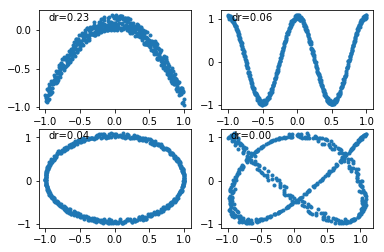

0.430243523378


In [4]:
#R-code
import try_distance_corr as dcor
x = np.random.uniform ( -1, 1,1000)

print(np.sqrt(dcor.dcov_all(x,x**2)[2]))

## 4. Model based ranking
Finally one can use an arbitrary machine learning method to build a predictive model for the response variable using each individual feature, and measure the performance of each model. In fact, this is already put to use with Pearson’s correlation coefficient, since it is equivalent to standardized regression coefficient that is used for prediction in linear regression. If the relationship between a feature and the response variable is non-linear, there are a number of alternatives, for example tree based methods (decision trees, random forest), linear model with basis expansion etc. Tree based methods are probably among the easiest to apply, since they can model non-linear relations well and don’t require much tuning. The main thing to avoid is overfitting, so the depth of tree(s) should be relatively small, and cross-validation should be applied.

Here’s univariate selection using sklearn’s random forest regressor on Boston housing price data set, a sample which includes housing prices in suburbs of Boston together with a number of key attributes.

In [5]:
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
 
#Load boston housing dataset as an example
boston = load_boston()
X = boston["data"]
Y = boston["target"]
names = boston["feature_names"]
 
rf = RandomForestRegressor(n_estimators=20, max_depth=4)
scores = []
for i in range(X.shape[1]):
     score = cross_val_score(rf, X[:, i:i+1], Y, scoring="r2",
                              cv=ShuffleSplit(len(X), 3, .3))
     scores.append((round(np.mean(score), 3), names[i]))
print (sorted(scores, reverse=True))

C:\Users\mfp53502\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[(0.66200000000000003, 'LSTAT'), (0.54200000000000004, 'RM'), (0.40000000000000002, 'NOX'), (0.34200000000000003, 'TAX'), (0.30599999999999999, 'PTRATIO'), (0.26700000000000002, 'INDUS'), (0.21099999999999999, 'ZN'), (0.19400000000000001, 'CRIM'), (0.14399999999999999, 'B'), (0.097000000000000003, 'AGE'), (0.085000000000000006, 'RAD'), (0.048000000000000001, 'DIS'), (0.045999999999999999, 'CHAS')]


There are a few things to keep in mind when using the impurity based ranking. Firstly, feature selection based on impurity reduction is biased towards preferring variables with more categories (see Bias in random forest variable importance measures). Secondly, when the dataset has two (or more) correlated features, then from the point of view of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others. But once one of them is used, the importance of others is significantly reduced since effectively the impurity they can remove is already removed by the first feature. As a consequence, they will have a lower reported importance. This is not an issue when we want to use feature selection to reduce overfitting, since it makes sense to remove features that are mostly duplicated by other features. But when interpreting the data, it can lead to the incorrect conclusion that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable.

The effect of this phenomenon is somewhat reduced thanks to random selection of features at each node creation, but in general the effect is not removed completely. In the following example, we have three correlated variables X0,X1,X2, and no noise in the data, with the output variable simply being the sum of the three features:

In [6]:
size = 10000
np.random.seed(seed=10)
X_seed = np.random.normal(0, 1, size)
X0 = X_seed + np.random.normal(0, .1, size)
X1 = X_seed + np.random.normal(0, .1, size)
X2 = X_seed + np.random.normal(0, .1, size)
X = np.array([X0, X1, X2]).T
Y = X0 + X1 + X2
  
rf = RandomForestRegressor(n_estimators=20, max_features=2)
rf.fit(X, Y);
print ("Scores for X0, X1, X2:",rf.feature_importances_)


Scores for X0, X1, X2: [ 0.27236571  0.54836524  0.17926905]


## When we compute the feature importances, we see that X1 is computed to have over 2x higher importance than X2, while their “true” importance is very similar. This happens despite the fact that the data is noiseless, we use 20 trees, random selection of features (at each split, only two of the three features are considered) and a sufficiently large dataset.

Ref: http://blog.datadive.net/selecting-good-features-part-iii-random-forests/